# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

# Preliminaries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
df = pd.read_csv('recipe_site_traffic_2212.csv')
df

recipe  calories  carbohydrate  ...      category  servings high_traffic
0         1       NaN           NaN  ...          Pork         6         High
1         2     35.48         38.56  ...        Potato         4         High
2         3    914.28         42.68  ...     Breakfast         1          NaN
3         4     97.03         30.56  ...     Beverages         4         High
4         5     27.05          1.85  ...     Beverages         4          NaN
..      ...       ...           ...  ...           ...       ...          ...
942     943   1161.00          5.31  ...  Lunch/Snacks         2          NaN
943     944       NaN           NaN  ...        Potato         2         High
944     945    951.74         29.42  ...          Pork         2         High
945     946    266.61         35.77  ...        Potato         6         High
946     947    184.56         45.21  ...     Beverages         4          NaN

[947 rows x 8 columns]

# Data Validation
Only the _servings_ column has the wrong datatype

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Then looking at the unique values, we see that _servings_ also has values with 'as a snack'. Also, _high_traffic_ is either 'High' or null.

In [55]:
for column in df.select_dtypes(exclude=[np.number]).columns:
    print(column, df[column].unique())

category ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
servings ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
high_traffic ['High' nan]


We remove the 'as a snack' term, as it has no effect on the number of servings. Converting the datatype of _servings_ to int. Replacing 'Chicken Breast' with just 'Chicken'

In [56]:
clean_df = df.copy()

clean_df['servings'] = df['servings'].str.replace(' as a snack', '').astype(int)
print(
    clean_df['servings'].unique(),
    clean_df['servings'].dtypes
)
clean_df['category'] = df['category'].str.replace(' Breast', '')
print(
    clean_df['category'].unique()
)

[6 4 1 2] int64
['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']


We also replace the data of _high_traffic_ into int, where 1 represent high traffic, and 0 if low.

In [57]:
clean_df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x=='High' else 0)
print(
    clean_df['high_traffic'].unique(),
    clean_df['high_traffic'].dtypes
)

[1 0] int64


5.5% of recipes have missing data.

In [58]:
null = clean_df.isna().any(axis=1).sum()/len(clean_df)*100
print(f"{null:.2f} % of recipes have missing data.")

5.49 % of recipes have missing data.


We also see that the whole recipes themselves are the missing data, i.e. no recipe has some missing values for the nutrient, all of them are.

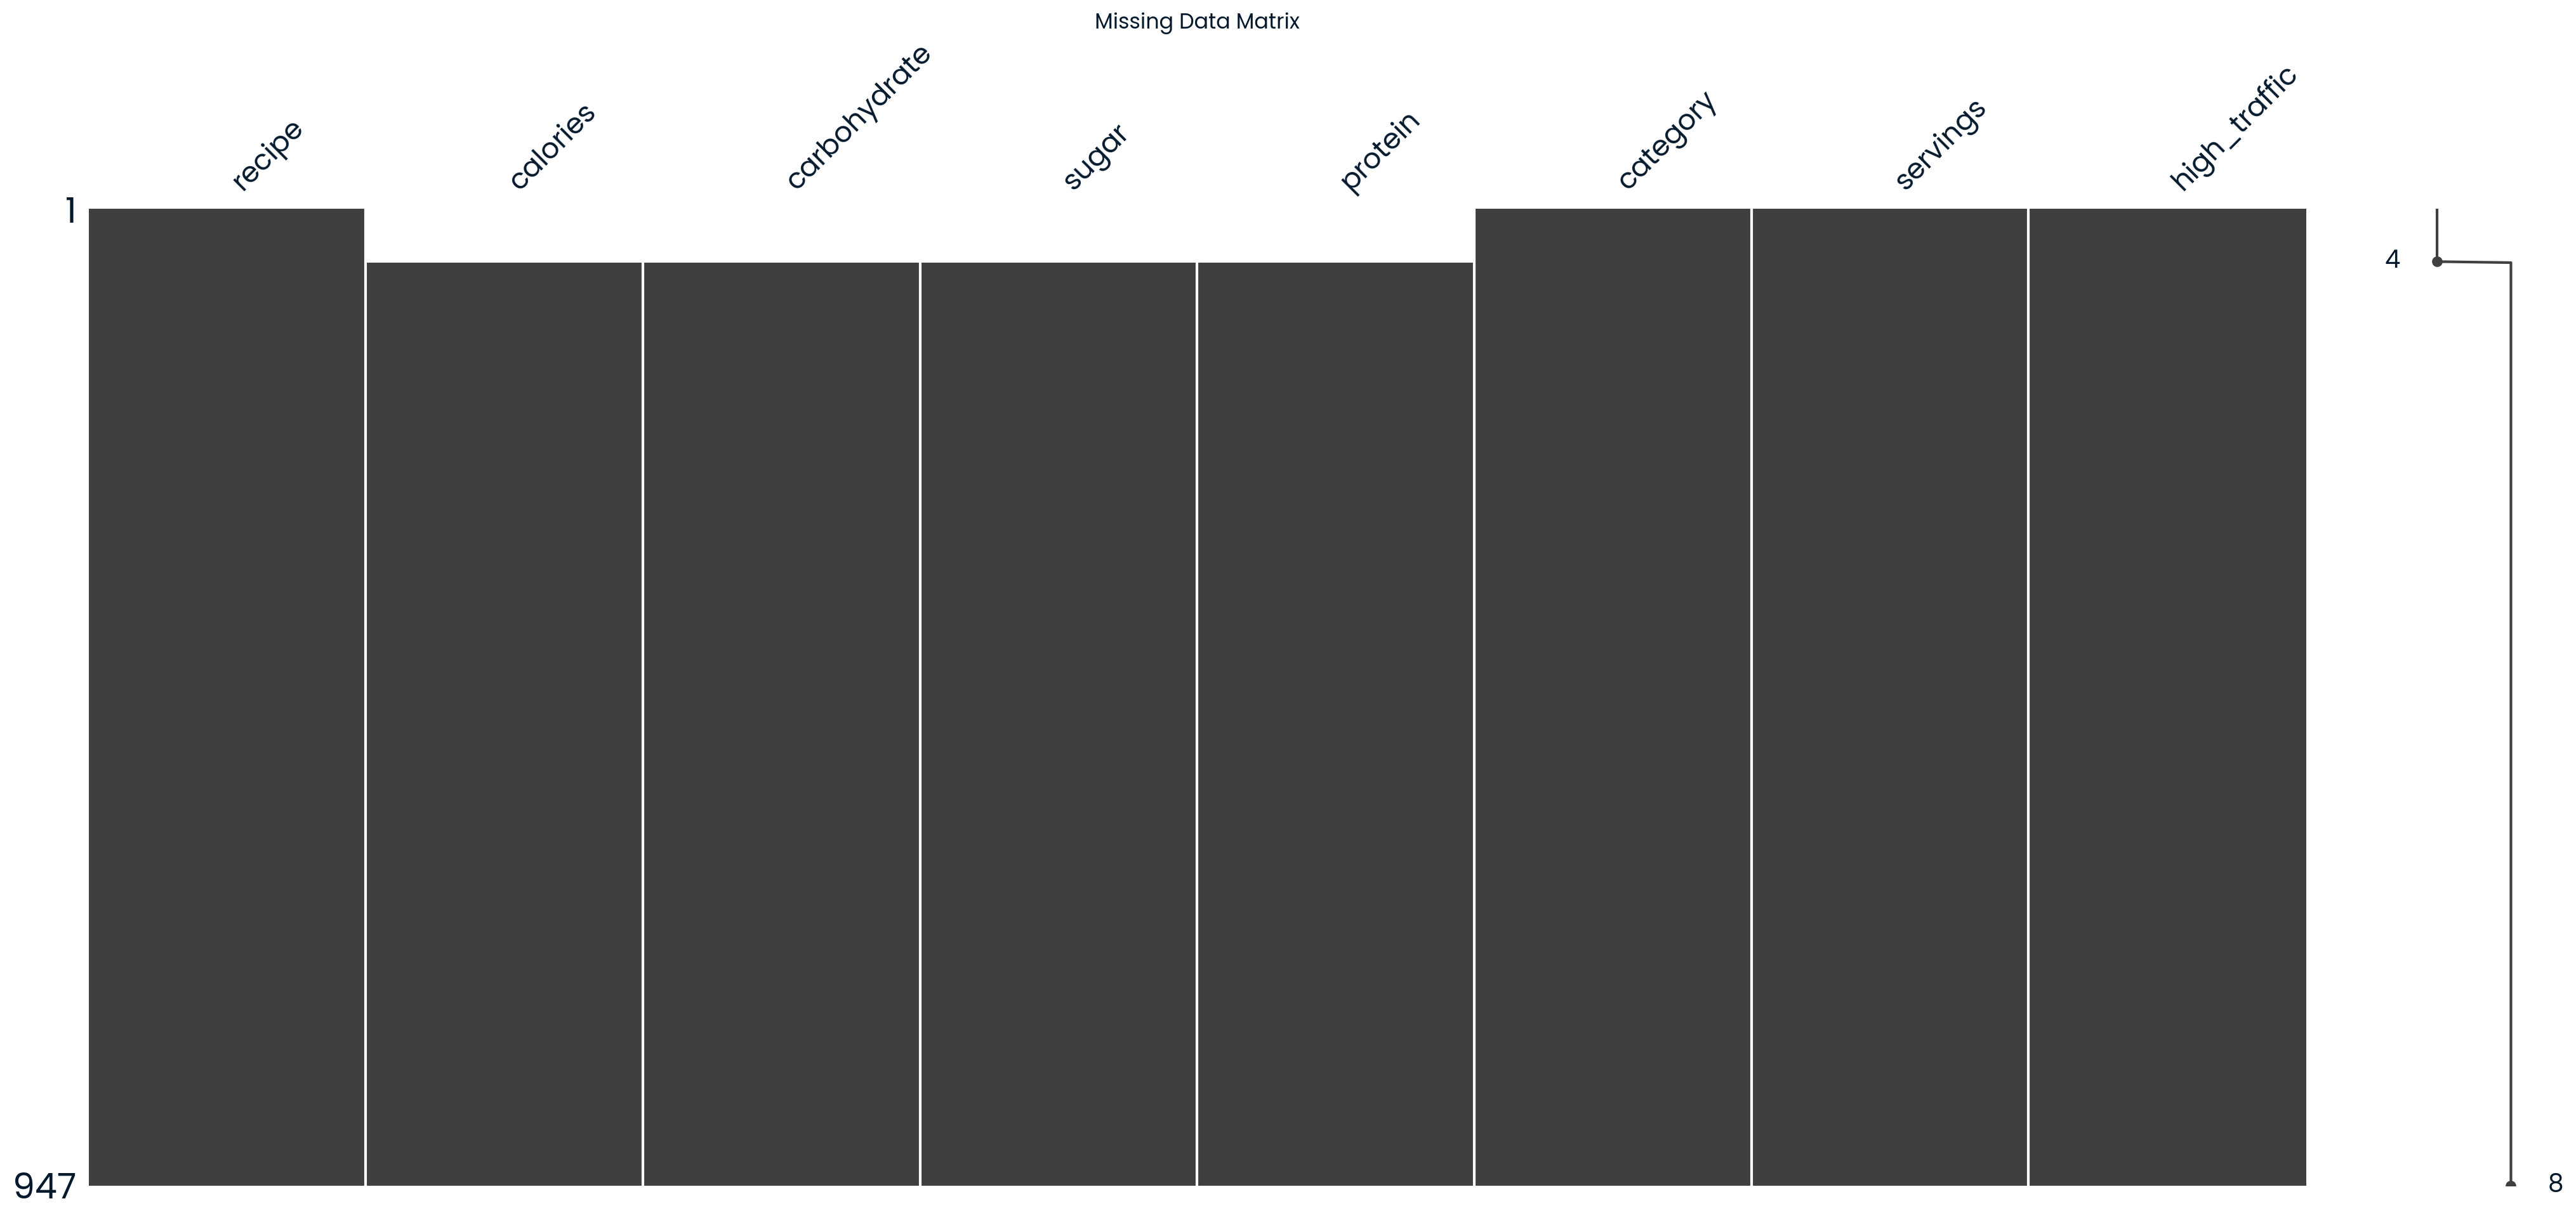

In [59]:
import missingno as msno
msno.matrix(clean_df, sort='ascending')
plt.title("Missing Data Matrix")
plt.show()

We can't just guess whole recipes based on other data, so we will just omit all the missing data 

In [60]:
clean_df = clean_df.dropna()

There is something fundamentally wrong with the dataset for multiple reasons.

1. Sugar, is a carbohydrate (https://sugar.ca/sugar-basics/frequently-asked-questions-about-sugar/nutritional-value), and in the dataset, they are considered separate. Also, we see that in some recipes, the amount of sugar in grams is greater than the amount of carbohydrate in grams, which is impossible.

In [61]:
clean_df[clean_df['carbohydrate']<clean_df['sugar']]

recipe  calories  carbohydrate  ...      category  servings high_traffic
3         4     97.03         30.56  ...     Beverages         4            1
11       12    155.80          8.27  ...     Breakfast         6            0
14       15    217.14          6.69  ...          Meat         4            1
15       16    316.45          2.65  ...          Meat         6            1
16       17    454.27          1.87  ...          Meat         2            1
..      ...       ...           ...  ...           ...       ...          ...
916     917     64.27          0.16  ...     Beverages         2            0
924     925    199.20          0.69  ...     Beverages         4            0
935     936    262.29         60.13  ...       Dessert         4            1
936     937    164.86          1.62  ...          Pork         4            1
942     943   1161.00          5.31  ...  Lunch/Snacks         2            0

[185 rows x 8 columns]

2. Also, each nutritional element provides calories; 4 calories per gram of the carbohydrates and proteins (https://www.nal.usda.gov/programs/fnic). If we calculate the amount of calories each column provides, we get that there are recipes with less calories than the amount of calories each nutritional element should provide, regardless if we consider the sugar column or not.

In [62]:
clean_df[clean_df['calories']<4*clean_df[['carbohydrate', 'sugar', 'protein']].sum(axis=1)]

recipe  calories  carbohydrate  ...   category  servings high_traffic
1         2     35.48         38.56  ...     Potato         4            1
3         4     97.03         30.56  ...  Beverages         4            1
6         7    183.94         47.95  ...    Chicken         4            0
9        10    248.28         48.54  ...    Chicken         2            0
13       14     25.23         11.51  ...  Vegetable         4            1
..      ...       ...           ...  ...        ...       ...          ...
935     936    262.29         60.13  ...    Dessert         4            1
936     937    164.86          1.62  ...       Pork         4            1
937     938    126.31         45.48  ...    Dessert         1            1
941     942    186.21         83.94  ...    Chicken         4            1
946     947    184.56         45.21  ...  Beverages         4            0

[376 rows x 8 columns]

In [63]:
clean_df[clean_df['calories']<4*clean_df[['carbohydrate', 'protein']].sum(axis=1)]

recipe  calories  carbohydrate  ...   category  servings high_traffic
1         2     35.48         38.56  ...     Potato         4            1
3         4     97.03         30.56  ...  Beverages         4            1
6         7    183.94         47.95  ...    Chicken         4            0
9        10    248.28         48.54  ...    Chicken         2            0
13       14     25.23         11.51  ...  Vegetable         4            1
..      ...       ...           ...  ...        ...       ...          ...
931     932    110.17         65.70  ...    Dessert         1            1
933     934     47.74          5.33  ...    Chicken         4            1
936     937    164.86          1.62  ...       Pork         4            1
937     938    126.31         45.48  ...    Dessert         1            1
941     942    186.21         83.94  ...    Chicken         4            1

[324 rows x 8 columns]

In [64]:
sugar_percentage = len(clean_df[clean_df['carbohydrate']<clean_df['sugar']])/len(clean_df)*100
calorie_percentage = len(clean_df[clean_df['calories']<4*clean_df[['carbohydrate', 'sugar', 'protein']].sum(axis=1)])/len(clean_df)*100
calorie_no_sugar_percentage = len(clean_df[clean_df['calories']<4*clean_df[['carbohydrate', 'protein']].sum(axis=1)])/len(clean_df)*100
print(f"Percentage of recipes with more sugar than carbohydrate is {sugar_percentage:.2f} %. Percentage of data with less calories than the calories of the nutritional elements is {calorie_percentage:.2f} % or {calorie_no_sugar_percentage:.2f} % if we ignore the sugar content.")

Percentage of recipes with more sugar than carbohydrate is 20.67 %. Percentage of data with less calories than the calories of the nutritional elements is 42.01 % or 36.20 % if we ignore the sugar content.


These wrong recipes are a significant percentage of the total dataset, so omitting is impossible. But we still continue on the analysis under the assumption that the data is correct.

# Exploratory Analysis

In [65]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score

First, we plot the percentage of recipes with high and low traffic for each category. We then check if the difference between the percentages of high and low traffic for each category is significant using binomial test.

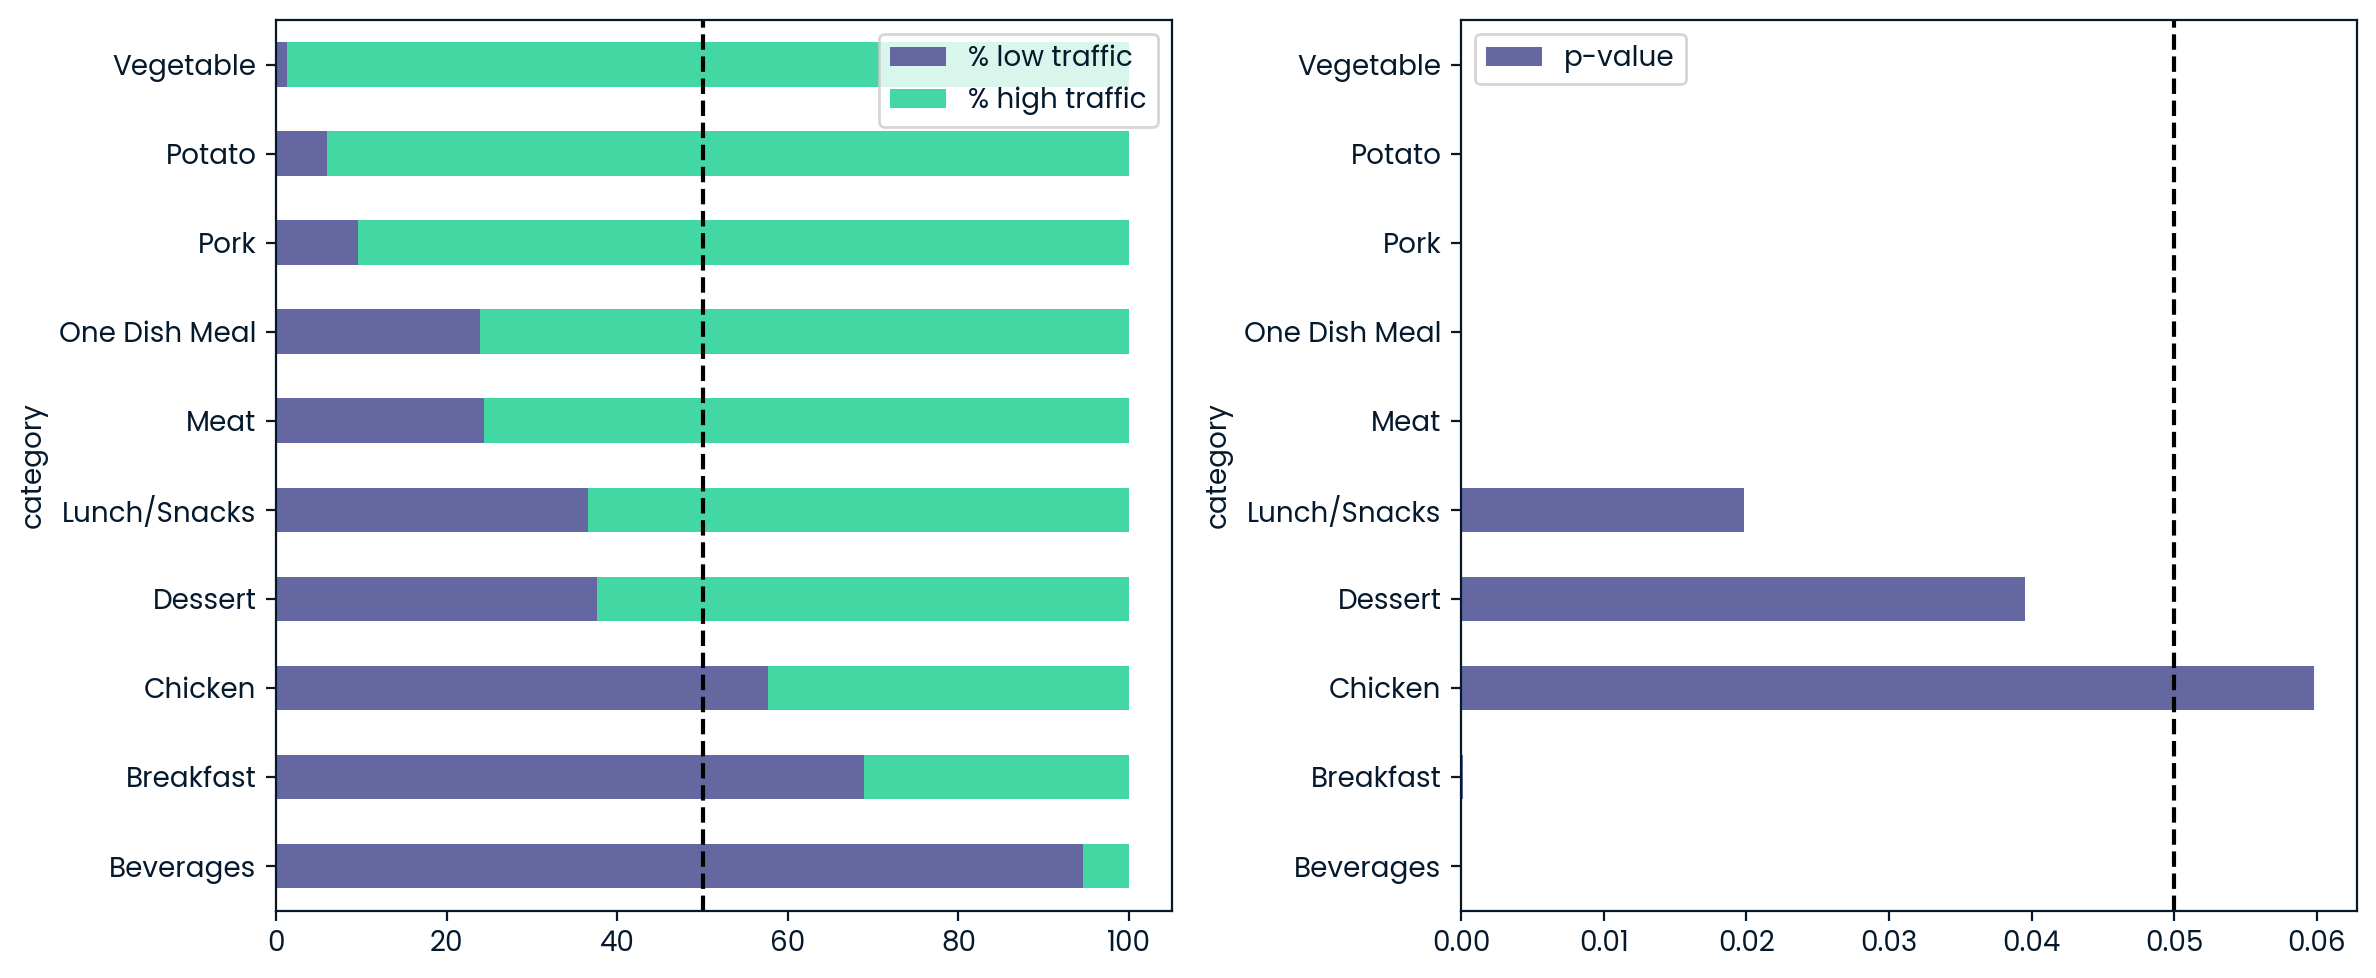

In [66]:
stacked_plot_df = pd.crosstab(clean_df["category"], clean_df["high_traffic"], normalize="index")*100
stacked_plot_df.columns = ["% low traffic", "% high traffic"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

stacked_plot_df.plot(kind="barh", stacked=True, ax=axes[0])
axes[0].axvline(x=50, c="k", linestyle='--')

cat_p_val_dict = [] 
for cat in stacked_plot_df.sort_values(by="% high traffic").index:
    cat_df = clean_df[clean_df["category"]==cat]
    cat_p_val_dict.append({
        "p-value": stats.binomtest(k=cat_df["high_traffic"].sum(), n=len(cat_df), p=0.5, alternative="two-sided").pvalue
    })
pd.DataFrame(cat_p_val_dict, index=stacked_plot_df.sort_values(by="% high traffic").index).plot(kind="barh", ax=axes[1])
axes[1].axvline(x=0.05, c="k", linestyle='--')
plt.tight_layout()
plt.show()

Recipe categories with significantly high general traffic are Vegetable, Potato, Pork, One Dish Meal, and Meat. Those with significantly low general traffic are Breakfast and Beverages.

We plot the distributions for each nutrional value, comparing for high and low traffic recipes. We also take the scatterplots of each possible pair of these values.

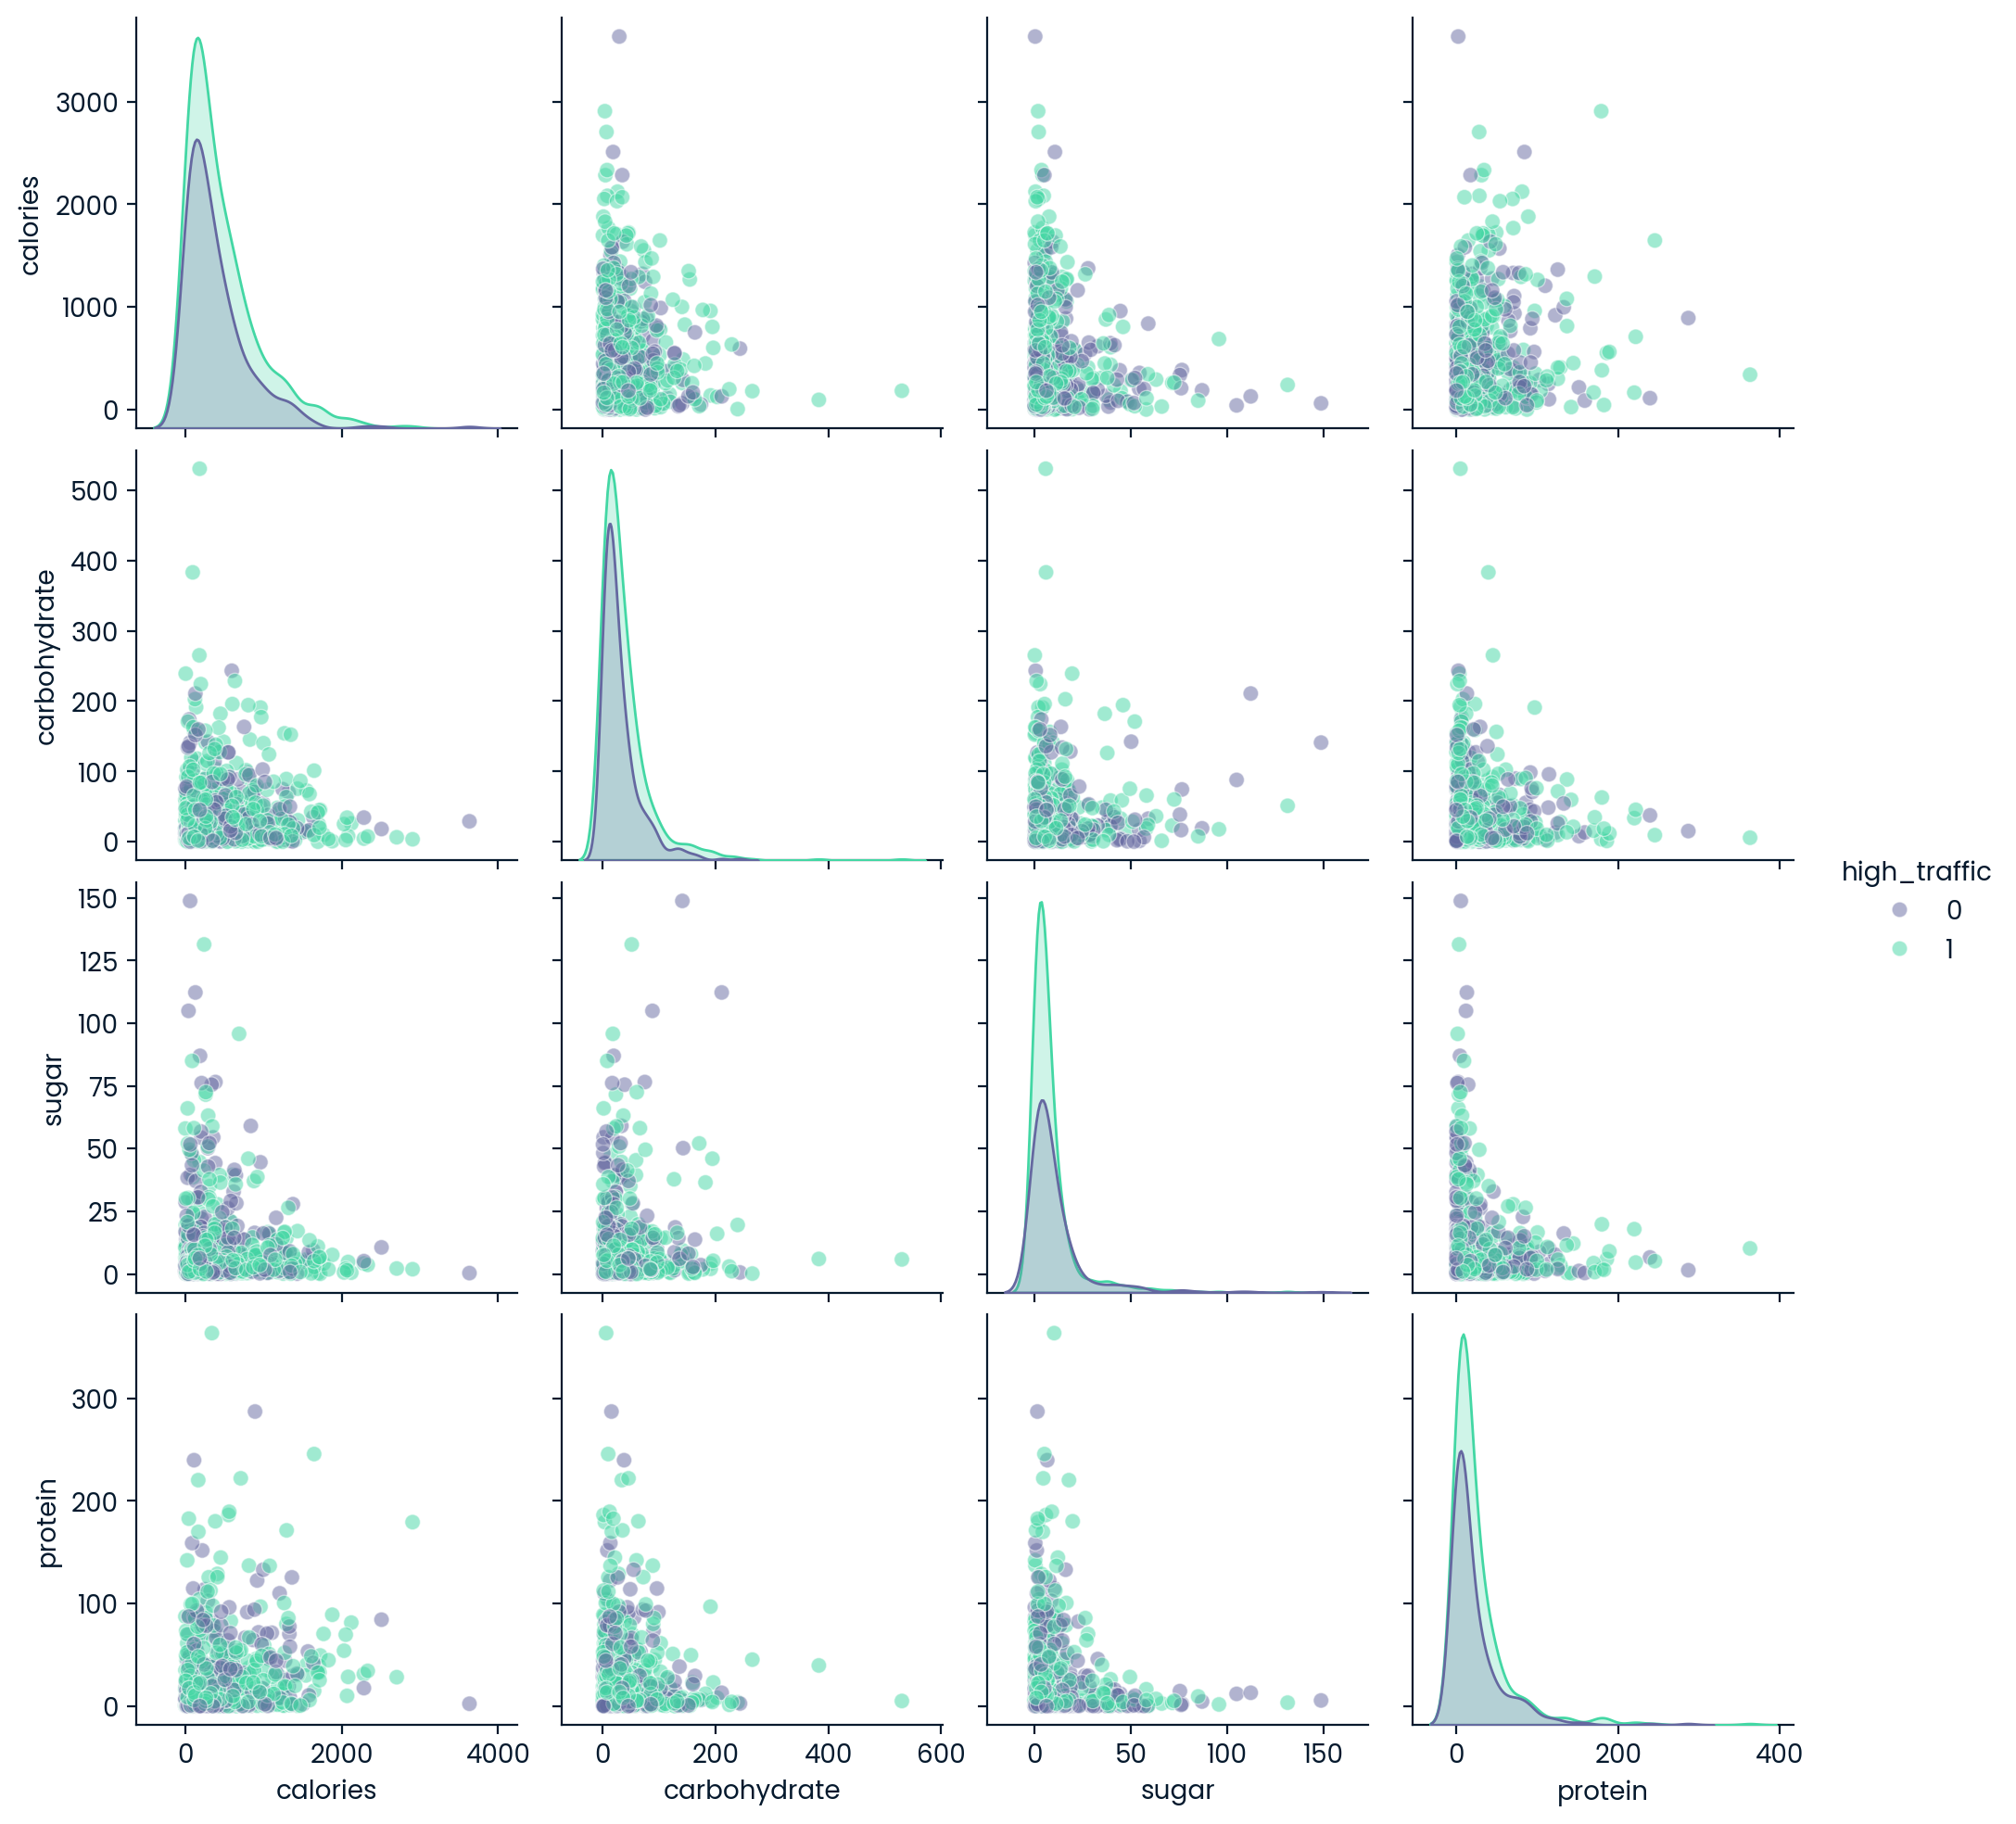

In [67]:
cols = ['calories', 'carbohydrate', 'sugar', 'protein']
sns.pairplot(clean_df, vars=cols, hue='high_traffic', plot_kws={'alpha':0.5})
plt.show()

The data is heavily right-skewed, so we take the logarithm of the values, where we use log(1+x) instead, as there is a 0 value for one of the recipes.

In [68]:
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    clean_df['log_'+col]  = np.log(1+clean_df[col])

Most of the scatterplots are very noisy, and some distributions cannot be normalized, i.e. some distributions are not unimodal.

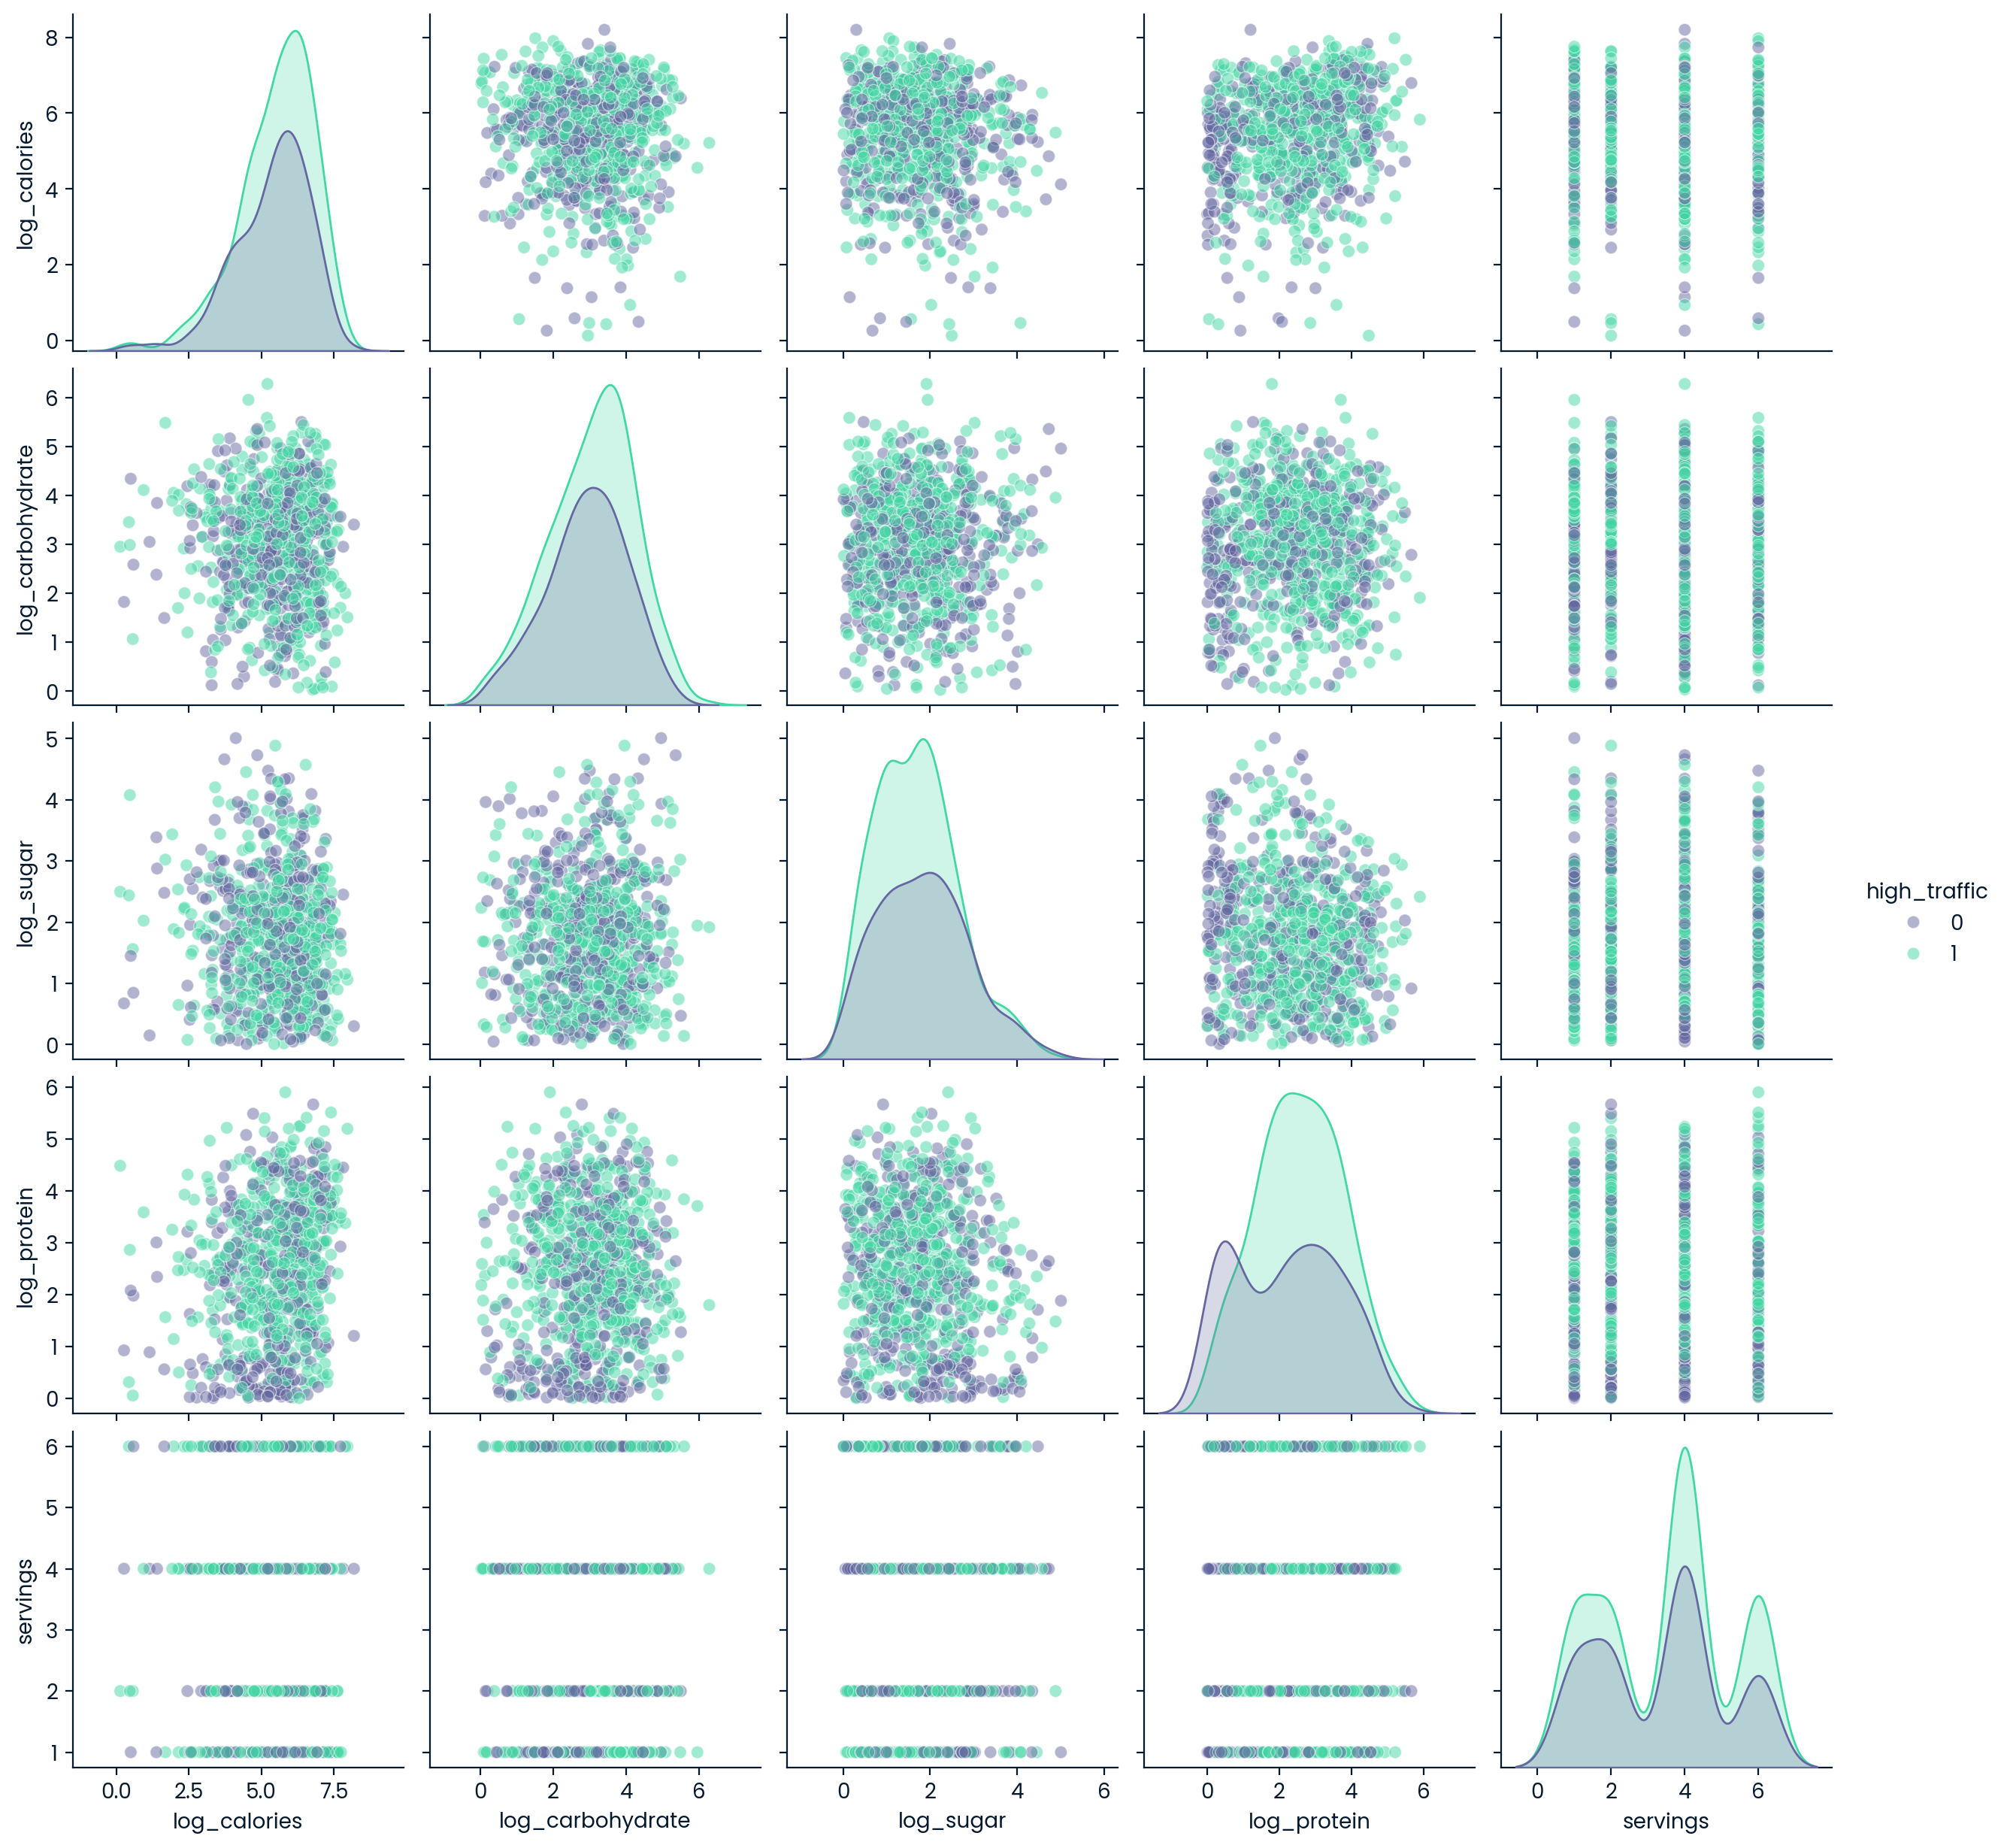

In [69]:
cols = ['calories', 'carbohydrate', 'sugar', 'protein']
log_cols = [*["log_"+col for col in cols], 'servings']
sns.pairplot(clean_df, vars=log_cols, hue='high_traffic', plot_kws={'alpha':0.5})
plt.show()

# Model Development and Evaluation

We want to predict a binary classification (high or low traffic), we will use models such as Logistic Regression and Random Forest. We first separate the dataset into a training and test data.

In [70]:
random_seed = 13
X = clean_df.drop(['recipe', 'high_traffic', *cols], axis=1)
y = clean_df['high_traffic']

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

In [71]:
preprocessor_scale = ColumnTransformer(
    transformers=[
        ('pass', 'passthrough', list(filter(lambda x: x not in log_cols,list(X_train.columns)))),
        ('scale', StandardScaler(), log_cols),
    ]
)

logreg_model = Pipeline([
    ('preprocessor', preprocessor_scale),
    ('pca', PCA(n_components=9)),
    ('logreg', LogisticRegression(class_weight='balanced'))
])

forest_model = RandomForestClassifier(random_state=random_seed, class_weight='balanced')

The scoring metric we should use is the one that shows how often we correctly predict high traffic recipes, which are the positives in our case. So we will use precision to measure our model performance.

In [72]:
logreg_model.fit(X_train, y_train)
print(
    precision_score(y_train, logreg_model.predict(X_train))*100,
    precision_score(y_test, logreg_model.predict(X_test))*100
)

81.62162162162161 78.72340425531915


In [73]:
forest_model.fit(X_train, y_train)
print(
    precision_score(y_train, forest_model.predict(X_train))*100,
    precision_score(y_test, forest_model.predict(X_test))*100
)

100.0 75.47169811320755


We will now use hyperparameter tuning using RandomizedSearchCV.

In [74]:
forest_random_grid = {
    'n_estimators':stats.randint(200, 300),
    'max_depth': stats.randint(1, 5),
    'min_samples_split': stats.randint(5, 10),
    'min_samples_leaf': stats.randint(5, 10),
    'max_features':[None, "sqrt", "log2"]
}

In [75]:
randomized_forest_model = RandomizedSearchCV(forest_model, forest_random_grid, random_state=random_seed, scoring='precision').fit(X_train, y_train)

print(
    randomized_forest_model.best_score_*100, 
    precision_score(y_test, randomized_forest_model.best_estimator_.predict(X_test))*100,
    randomized_forest_model.best_params_
)

81.47902640656262 81.25 {'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 218}


We can further improve our model by removing the least important feature, to lessen the "noise" for our classifier.

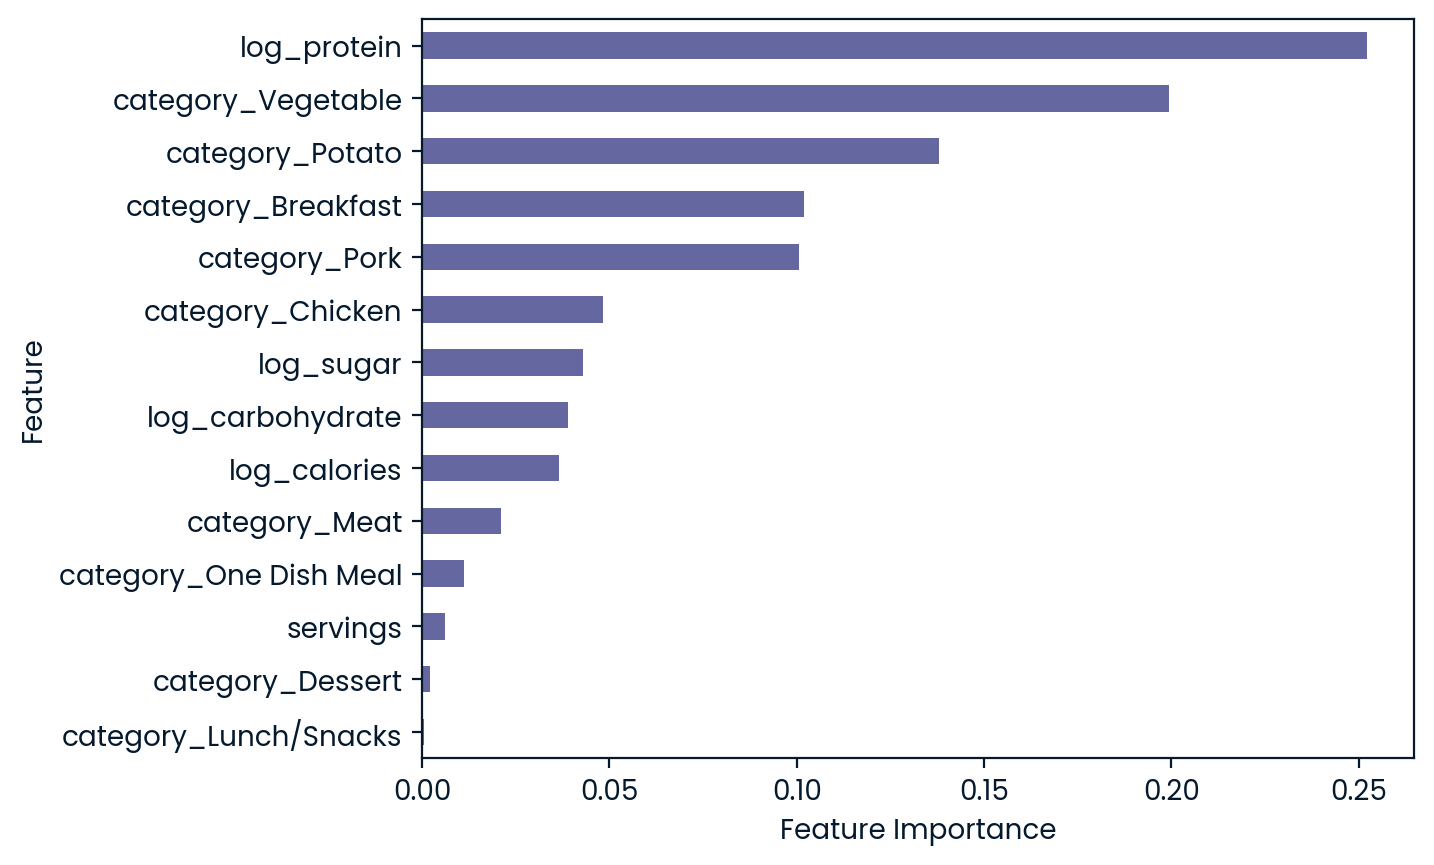

In [76]:
feature_df = pd.Series(data=randomized_forest_model.best_estimator_.feature_importances_, index=X_train.columns)
feature_df = feature_df.sort_values()
feature_df.plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

We'll continuously remove the least important feature, and compare their precision in a plot.

In [77]:
min_importance = 0
features_to_drop = [feature_df.idxmin()]
new_X_train, new_X_test = X_train, X_test
feature_dict = [{
        "train_precision": precision_score(y_train, randomized_forest_model.best_estimator_.predict(X_train))*100,
        "test_precision": precision_score(y_test, randomized_forest_model.best_estimator_.predict(X_test))*100,
        "feature_dropped": "None"
    }]
best_estimator = randomized_forest_model.best_estimator_
while min_importance<0.01:
    new_X_train, new_X_test, _, _= train_test_split(X.drop(features_to_drop, axis=1), y, test_size=0.2, random_state=random_seed, stratify=y)
    best_estimator.fit(new_X_train, y_train)
    series = pd.Series(data=randomized_forest_model.best_estimator_.feature_importances_, index=new_X_train.columns)
    feature_dict.append({
        "train_precision": precision_score(y_train, best_estimator.predict(new_X_train))*100,
        "test_precision": precision_score(y_test, best_estimator.predict(new_X_test))*100,
        "feature_dropped": features_to_drop[-1]
    })
    min_importance = series.min()
    features_to_drop.append(series.idxmin())
feature_df = pd.DataFrame(feature_dict)

We see that removing the "Lunch/Snacks" category improves the precision, but removing more features generally reduces it, so in our model, we will only remove one feature.

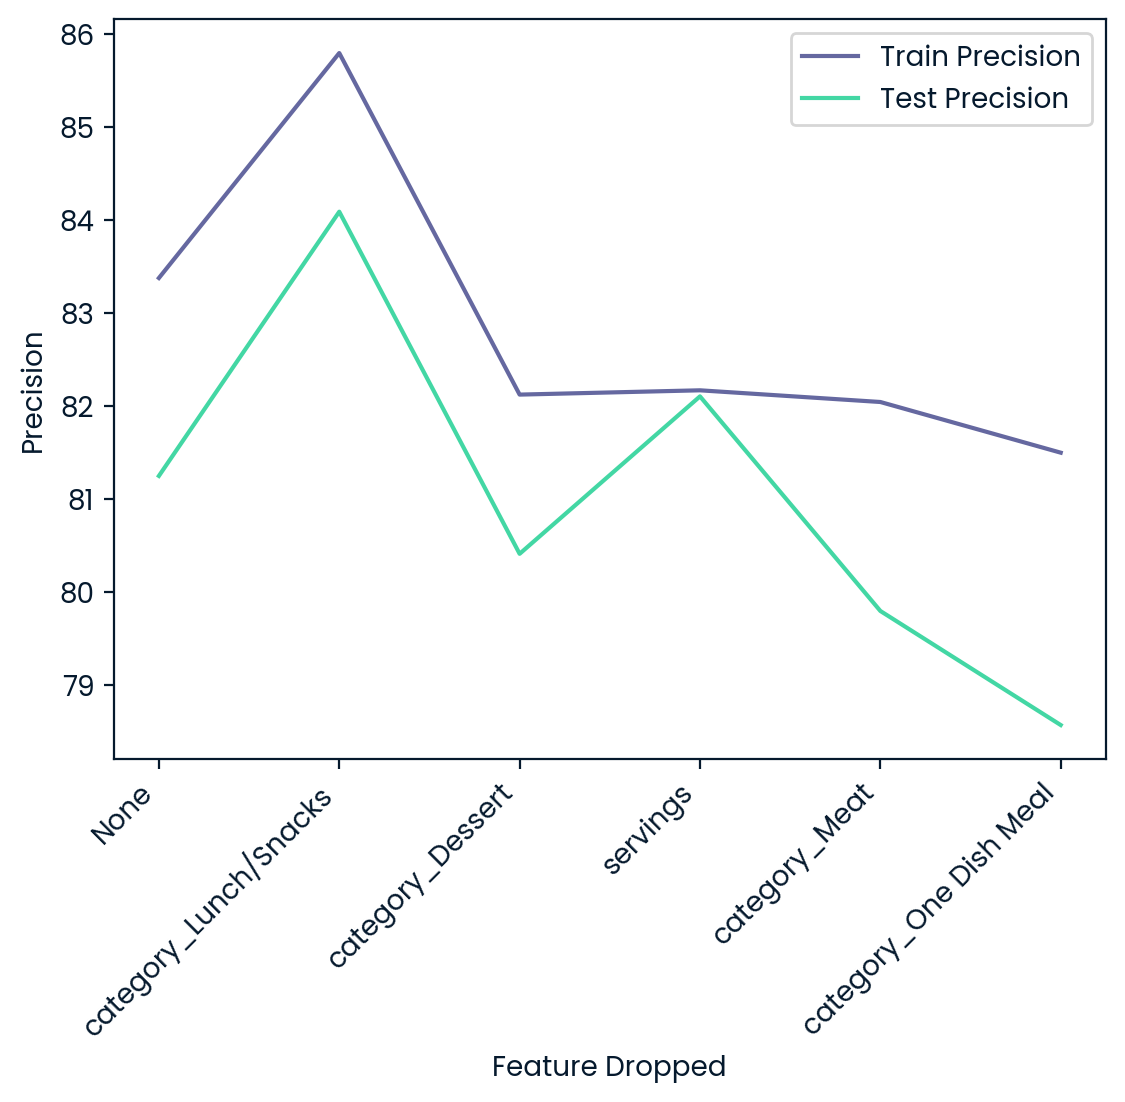

In [78]:
sns.lineplot(data=feature_df, x='feature_dropped', y="train_precision", label="Train Precision")
sns.lineplot(data=feature_df, x='feature_dropped', y="test_precision", label="Test Precision")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Dropped")
plt.ylabel("Precision")
plt.show()

# Business Metrics

Precision is an appropriate metric to judge the model's effectiveness for business use. Our model meets the precision goal of 80%, meaning that our model should be able to predict the recipes that gives high traffic to the website 80% of the time. So those recipes should be displayed more often in the website.

For future use of this model, precision should be further monitored by continuing the collection of the data for recipes that give high and low traffic. This ensures the effectiveness and adaptability of our model.

# Conclusions and Recommendations

For our company's website, certain recipes being displayed in the home page provide higher traffic to the whole website. After validating and cleaning the data, we directly analyzed it, and found that recipes of certain categories generally provide significant traffic changes. Vegetable, Potato, Pork, One Dish Meal, and Meat recipes provide significantly higher traffic, and Breakfast and Beverage recipes provide significantly lower traffic.

Since we want to predict a binary value, ("high" or "low" traffic), Random Forest was used and compared against the Logistic Regression model. We found that after hyperparameter tuning, our Random Forest model has a precision of >80% for both training at test data. This means that at least for our given dataset, the recipes that provide high website traffic can be predicted more than 80% of the time.

Some observations about the dataset are concerning
- some categories are subcategories of other recipes, e.g. we have separate meat, pork, chicken, and chicken breast categories. Also, these categories are not mutually exclusive; some recipe can be both breakfast and meat, etc.
- Sugar and carbohydrates are considered separate, even though sugar is a carbohydrate. Some recipes even have higher sugar content than carbohydrate.
- Some recipes have lower displayed calories than the calories that are provided by the nutritional content.

These should be looked upon by whoever produced these recipes, not only for better ML prediction, but also for correct nutritional labeling and user trust.

Another recommendation, is to actually provide the % change in traffic from each recipe. This would require more complex machine learning models, but would provide a more accurate picture of the effect of each recipe, and may aid in the development of a better metric for business use. 


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation